# 필요 라이브러리 다운 및 코랩 마운트


In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import LSTM
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


#데이터 불러오기(1차, 2차)

In [3]:
#원데이터
raw_data1=pd.read_csv("/gdrive/My Drive/Colab Notebooks/daycon/dacon_cup/train.csv", encoding='euc-kr')
raw_data2=pd.read_csv("/gdrive/My Drive/Colab Notebooks/daycon/dacon_cup/2차_train.csv", encoding='euc-kr')
raw_data=pd.concat([raw_data1,raw_data2])

print(len(raw_data1),len(raw_data2))

19008 720


In [4]:
raw_data

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2018-09-09 00:00:00,19,19,8,206
1,2018-09-09 01:00:00,20,19,9,259
2,2018-09-09 02:00:00,12,9,1,48
3,2018-09-09 03:00:00,10,10,2,102
4,2018-09-09 04:00:00,6,5,3,18
...,...,...,...,...,...
715,2020-12-08 19:00:00,118,121,27,3337
716,2020-12-08 20:00:00,182,184,58,4600
717,2020-12-08 21:00:00,169,159,49,3983
718,2020-12-08 22:00:00,158,167,44,4578


# 전처리

In [ ]:
raw_data['DateTime'] = pd.to_datetime(raw_data['DateTime']) #시간type으로 변경
raw_data.set_index('DateTime', inplace=True) #시간을 인덱스로

In [ ]:
day_data=raw_data.resample("D").sum() #일단위로 합치기
day_data

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2018-09-09,281,266,73,1826
2018-09-10,264,247,51,2092
2018-09-11,329,310,58,1998
2018-09-12,300,287,45,2595
2018-09-13,378,344,50,3845
...,...,...,...,...
2020-12-04,3189,3068,743,75730
2020-12-05,2055,2019,497,47638
2020-12-06,2119,2077,460,46914


In [ ]:
#스케일링
scaler = preprocessing.MinMaxScaler()
scaler_fit = scaler.fit(day_data)
scaled_day_data=scaler_fit.transform(day_data)

scaled_day_data

array([[0.05168913, 0.04908316, 0.04260355, 0.01173496],
       [0.04855086, 0.04556399, 0.0295858 , 0.01344631],
       [0.06055012, 0.05723282, 0.03372781, 0.01284155],
       ...,
       [0.39099132, 0.38451565, 0.27159763, 0.30181493],
       [0.54975078, 0.5532506 , 0.44497041, 0.49822753],
       [0.5597194 , 0.55362104, 0.45621302, 0.4429883 ]])

In [ ]:
# 파라미터 설정
size=len(day_data)
sequence=7
dropout=0.3
epoch=180
batch_size=14
verbose=1

# 예측해야 하는구간 몇개인가?
dt_index = pd.date_range(start='20201209', end='20210108')
myIter=len(dt_index)

In [ ]:
# lstm, 1스텝 교차검사(one-step ahead cross-validation)
X_train,Y_train=[],[]

for i in range(size-sequence):
    X_train.append(np.array(scaled_day_data[i:i+sequence]))
    Y_train.append(np.array(scaled_day_data[i+sequence]))

X_train=np.array(X_train)
Y_train=np.array(Y_train)
print(len(X_train),len(Y_train))

#예측 해야할 개수만큼 반복
for i in range(myIter):
    print(i+1,"반복")
    # LSTM
    model = Sequential()
    model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
    model.add(Dropout(dropout)) 
    model.add(LSTM(64, activation="relu", return_sequences=False))
    model.add(Dropout(dropout)) 
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model_fit = model.fit(X_train, Y_train, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    #n+1일 값 찾기
    last_X=np.concatenate((X_train[-1][1:],np.array([Y_train[-1]])),axis=0)
    last_Y = model.predict(np.array([last_X]))
    
    #n+1일 값 추가
    new_X_train=np.concatenate((X_train[:],np.array([last_X])),axis=0)
    new_Y_train=np.concatenate((Y_train[:],last_Y),axis=0)
    
    X_train=np.array(new_X_train)
    Y_train=np.array(new_Y_train)

model.summary()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
60/60 [==============================] - 1s 18ms/step - loss: 0.0069
Epoch 44/180
60/60 [==============================] - 1s 16ms/step - loss: 0.0074
Epoch 45/180
60/60 [==============================] - 1s 20ms/step - loss: 0.0062
Epoch 46/180
60/60 [==============================] - 1s 18ms/step - loss: 0.0047
Epoch 47/180
60/60 [==============================] - 1s 19ms/step - loss: 0.0057
Epoch 48/180
60/60 [==============================] - 1s 21ms/step - loss: 0.0052
Epoch 49/180
60/60 [==============================] - 1s 20ms/step - loss: 0.0050
Epoch 50/180
60/60 [==============================] - 1s 21ms/step - loss: 0.0048
Epoch 51/180
60/60 [==============================] - 1s 23ms/step - loss: 0.0074
Epoch 52/180
60/60 [==============================] - 1s 19ms/step - loss: 0.0046
Epoch 53/180
60/60 [==============================] - 1s 20ms/step - loss: 0.0052
Epoch 54/180
60/60 [==============================] - 1s 20ms/step - loss: 

In [ ]:
# 출력확인
print(len(X_train),len(Y_train))

846 846


# 시각화

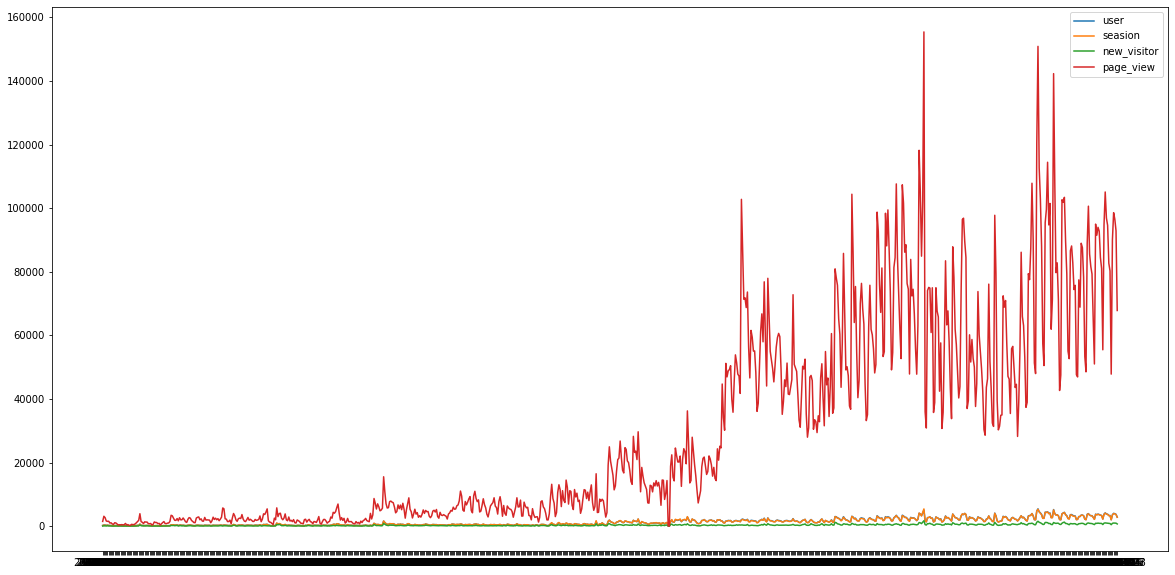

In [ ]:
# y시각화
Y_plot=pd.DataFrame(scaler.inverse_transform(Y_train))

Y_plot=Y_plot.rename({0:"사용자",1:"세션",2:"신규방문자",3:"페이지뷰"},axis="columns")
Y_plot

plot_index = pd.date_range(start='20180916', end='20210108')
Y_plot["DateTime"]=plot_index.strftime("%Y-%m-%d").tolist()

Y_plot.set_index('DateTime', inplace=True)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)

ax.plot(Y_plot["사용자"], label='user')
ax.plot(Y_plot["세션"], label='seasion')
ax.plot(Y_plot["신규방문자"], label='new_visitor')
ax.plot(Y_plot["페이지뷰"], label='page_view')

ax.legend()
plt.show()


# 제출파일 만들기

In [ ]:
sub_data = pd.DataFrame(scaler.inverse_transform(Y_train))[-61:] # 제출구간 자르기
sub_data=sub_data.rename({0:"사용자",1:"세션",2:"신규방문자",3:"페이지뷰"},axis="columns") #컬럼명 설정

In [ ]:
# 인덱스 만들기
dt_index = pd.date_range(start='20201109', end='20210108')
sub_data["DateTime"]=dt_index.strftime("%Y-%m-%d").tolist()

sub_data.set_index('DateTime', inplace=True)

In [ ]:
# 정수로 반올림
sub_data=sub_data.round(0)
sub_data

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2020-11-09,4364.0,4340.0,1143.0,95408.0
2020-11-10,4370.0,4256.0,1137.0,99623.0
2020-11-11,4492.0,4449.0,1071.0,114438.0
2020-11-12,3998.0,3899.0,796.0,94730.0
2020-11-13,4130.0,3967.0,835.0,101484.0
...,...,...,...,...
2021-01-04,3567.0,3495.0,871.0,90039.0
2021-01-05,4008.0,3932.0,963.0,98582.0
2021-01-06,3905.0,3839.0,934.0,96532.0


In [ ]:
#파일 쓰기
sub_data.to_csv("/gdrive/My Drive/Colab Notebooks/daycon/my_sub.csv",encoding='euc-kr',index=True)